<a href="https://colab.research.google.com/github/Jayanavya/PersonalMedicalCost_Prediction_Project/blob/main/Medical_Personal_Cost_Prediction_Quantile_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [ ]:
path = '/content/drive/MyDrive/Medical Personal Cost Prediction/insurance.csv'
df = pd.read_csv(path)
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


# **Exploratory Data Analysis**

In [ ]:
df.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [ ]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
# Convert categorical data to numerical for plotting
df['sex'] = df['sex'].map({'male': 0, 'female': 1})
df['smoker'] = df['smoker'].map({'no': 0, 'yes': 1})
df = pd.get_dummies(df, columns=['region'], drop_first=True)

In [ ]:
df

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,1,27.900,0,1,16884.92400,False,False,True
1,18,0,33.770,1,0,1725.55230,False,True,False
2,28,0,33.000,3,0,4449.46200,False,True,False
3,33,0,22.705,0,0,21984.47061,True,False,False
4,32,0,28.880,0,0,3866.85520,True,False,False
...,...,...,...,...,...,...,...,...,...
1333,50,0,30.970,3,0,10600.54830,True,False,False
1334,18,1,31.920,0,0,2205.98080,False,False,False
1335,18,1,36.850,0,0,1629.83350,False,True,False
1336,21,1,25.800,0,0,2007.94500,False,False,True


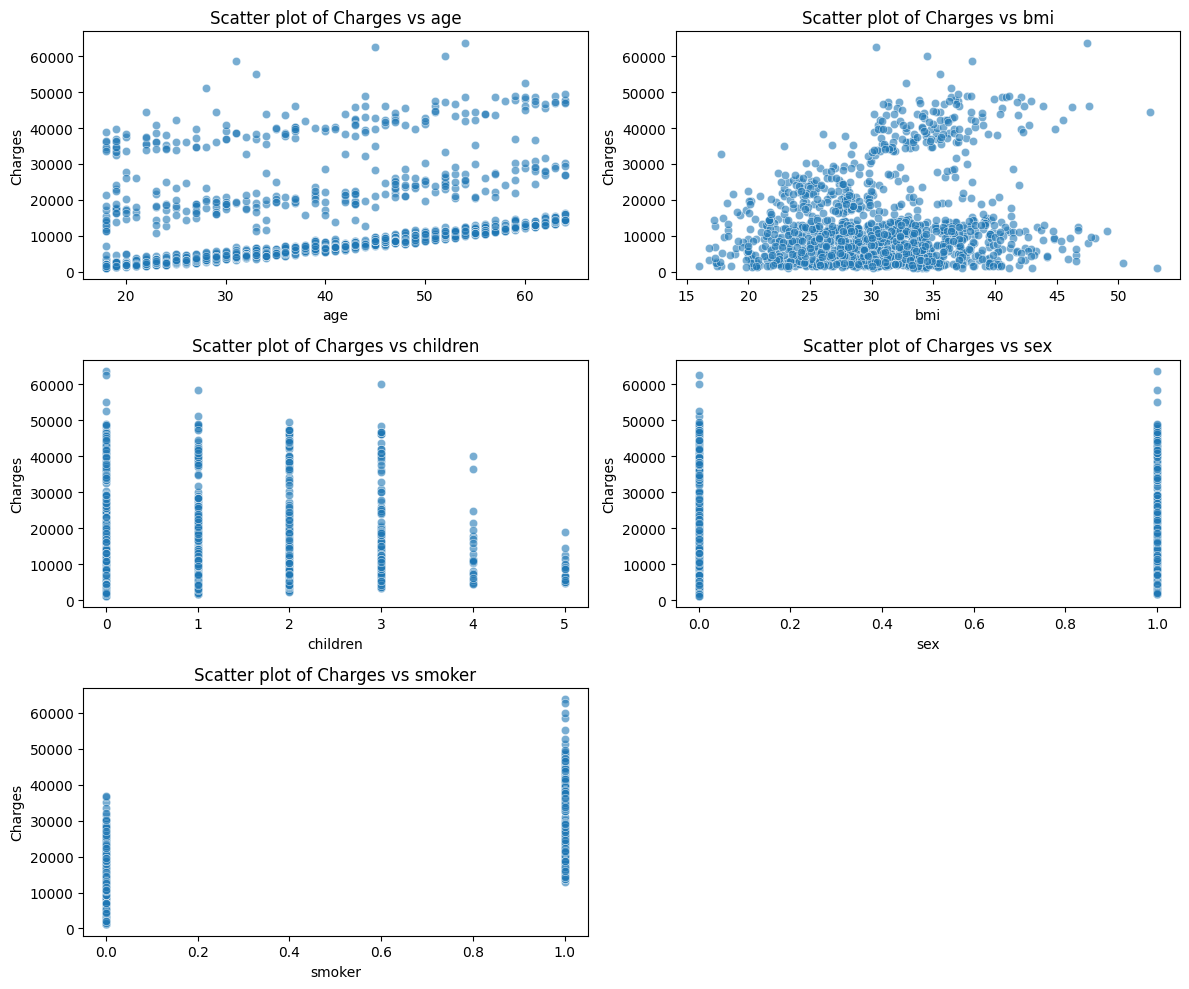

In [ ]:

# Create scatter plots between 'charges' and each numerical feature
numerical_features = ['age', 'bmi', 'children', 'sex', 'smoker']

plt.figure(figsize=(12, 10))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(data=df, x=feature, y='charges', alpha=0.6)
    plt.title(f'Scatter plot of Charges vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Charges')

plt.tight_layout()
plt.show()

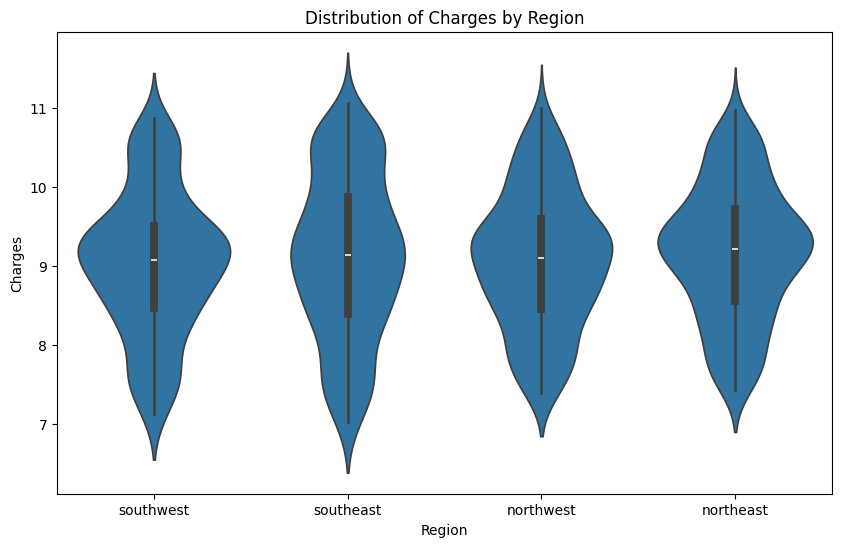

In [ ]:
# Adding a column for log-transformed charges
df['log_charges'] = np.log(df['charges'])

# Violin plot for charges by region
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='region', y='log_charges')
plt.title('Distribution of Charges by Region')
plt.xlabel('Region')
plt.ylabel('Charges')
plt.show()

The charge distribution by region is **relatively symmetric**, with slight variations in spread and outliers, indicating regional differences in healthcare costs.


Region wise, we can not see much difference in the distribution of the charges, we can see that there are more people in southeast region having higher medical cost, this might be helpful, but more or less these are having same distribution.

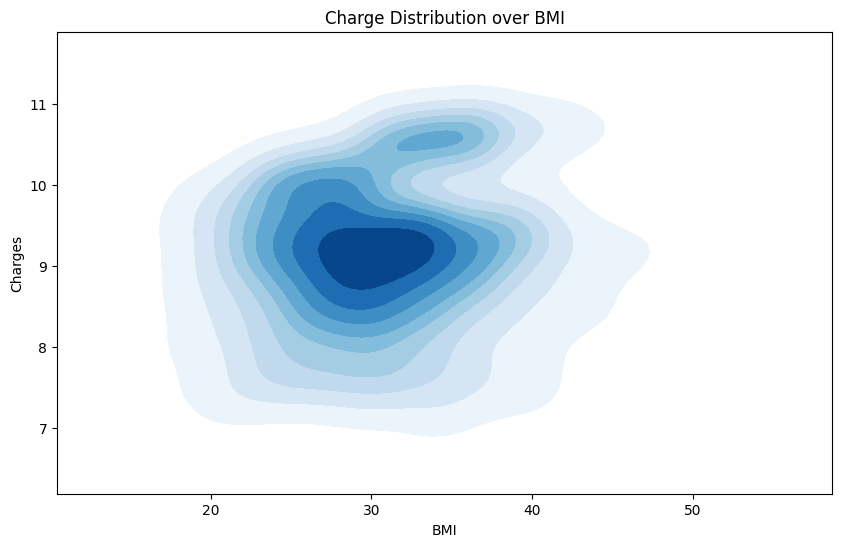

In [ ]:
# Create a distribution plot (kernel density estimate) for charges over BMI
plt.figure(figsize=(10, 6))
sns.kdeplot(x='bmi', y='log_charges', data=df, fill=True, cmap='Blues')
plt.title('Charge Distribution over BMI')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.show()

The charge distribution over BMI shows a **concentrated region** of charges around a BMI range of **25 to 35**, with the highest charges occurring in this area. As BMI increases beyond 35, the charge distribution becomes more **diffuse and less dense**, suggesting fewer cases with very high medical expenses in the higher BMI ranges. The plot indicates a gradual **increase** in charges as **BMI rises**, with a notable concentration of lower charges for individuals with lower BMI values.


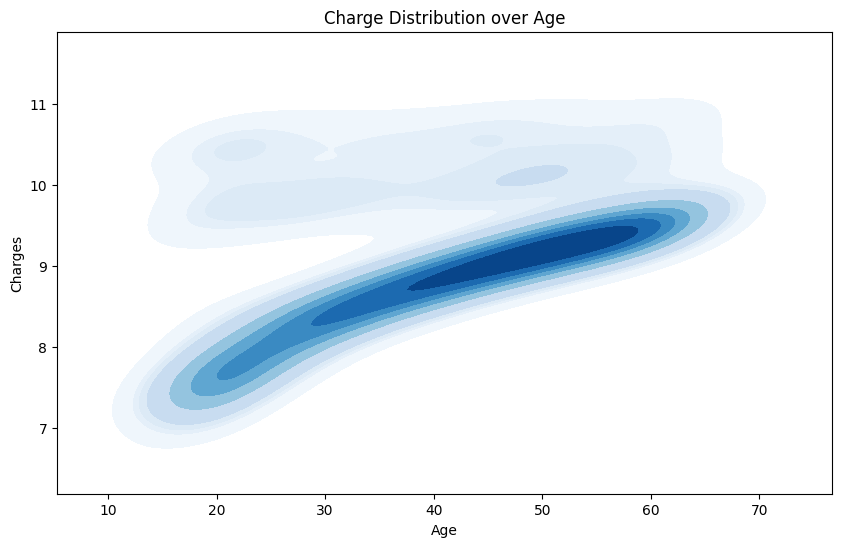

In [ ]:
# Create a distribution plot (kernel density estimate) for charges over BMI
plt.figure(figsize=(10, 6))
sns.kdeplot(x='age', y='log_charges', data=df, fill=True, cmap='Blues')
plt.title('Charge Distribution over Age')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.show()

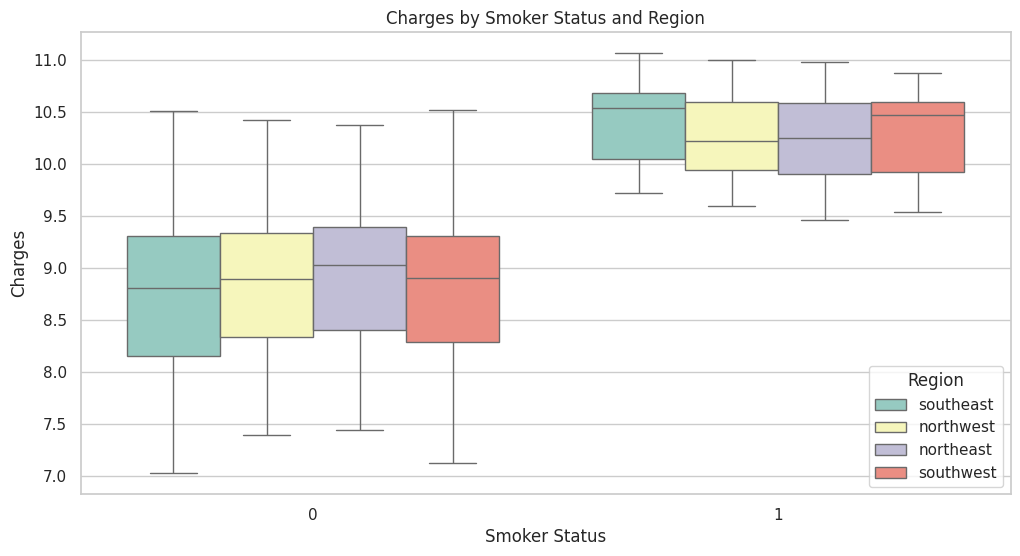

In [ ]:
# Box plot for charges by smoker status and region
plt.figure(figsize=(12, 6))
sns.boxplot(x='smoker', y='log_charges', hue='region', data=df, palette="Set3")
plt.title('Charges by Smoker Status and Region')
plt.xlabel('Smoker Status')
plt.ylabel('Charges')
plt.legend(title='Region')
plt.show()

Smokers incur higher medical charges than non-smokers across all regions.

Regional Differences: Smokers in the southeast region tend to have higher charges compared to other regions.

Non-smokers show more consistent, lower charges across regions.

Let's do some clustering in the BMI and Age scatter plots, it might give us some insights.

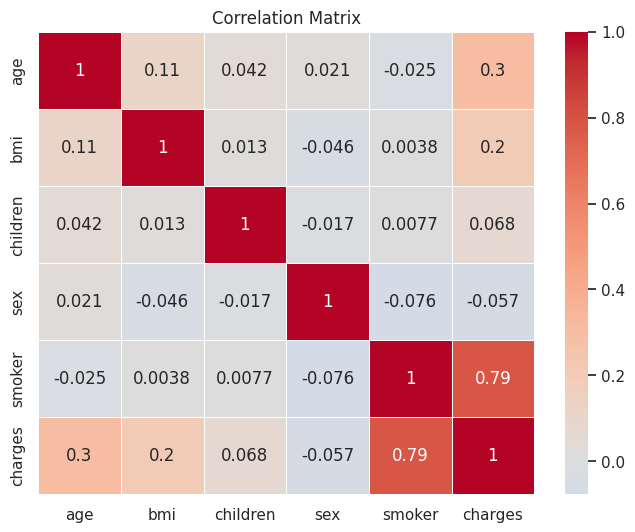

In [ ]:
corr_matrix = df[['age', 'bmi', 'children', 'sex', 'smoker', 'charges']].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

We can see a strong correlation between the Smokers and charges, which means smoking status is very much related to higher charges, which is quite obvious.

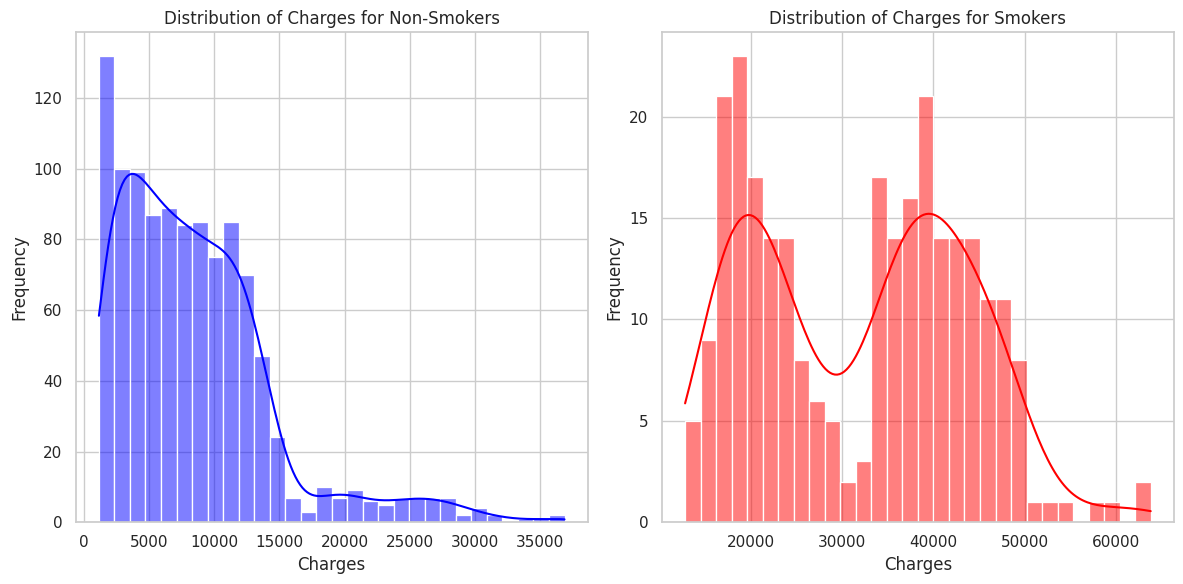

In [ ]:
# Create distribution plots for charges of smokers and non-smokers in separate subplots
plt.figure(figsize=(12, 6))

# Subplot for non-smokers
plt.subplot(1, 2, 1)
sns.histplot(data=df[df['smoker'] == 0], x='charges', kde=True, color='blue', bins=30)
plt.title('Distribution of Charges for Non-Smokers')
plt.xlabel('Charges')
plt.ylabel('Frequency')

# Subplot for smokers
plt.subplot(1, 2, 2)
sns.histplot(data=df[df['smoker'] == 1], x='charges', kde=True, color='red', bins=30)
plt.title('Distribution of Charges for Smokers')
plt.xlabel('Charges')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Smokers have a **right-skewed** distribution with charges concentrated in the 20,000-35,000 range, while non-smokers have a more **centered distribution**, typically lower in cost.


Distinct Peaks in Charges: The histogram highlights a clear separation between smokers and non-smokers in terms of charges. Non-smokers' charges tend to cluster toward the lower end, while smokers show a distribution skewed toward higher costs.

Distribution Differences: Non-smokers generally have a more compact, lower-cost distribution, whereas smokers have a broader, higher-cost distribution. This pattern reinforces the idea that smoking status is a critical feature for predicting medical expenses, as it significantly influences the cost.


### **Comparative Analysis of Smokers vs. Non-Smokers**

In [ ]:
from scipy import stats

# Split data into smokers and non-smokers
smokers = df[df['smoker'] == 1]
non_smokers = df[df['smoker'] == 0]

# Calculate summary statistics for log-transformed charges
smokers_stats = {
    "mean_log_charges": smokers['log_charges'].mean(),
    "median_log_charges": smokers['log_charges'].median(),
    "count": smokers['log_charges'].count()
}

non_smokers_stats = {
    "mean_log_charges": non_smokers['log_charges'].mean(),
    "median_log_charges": non_smokers['log_charges'].median(),
    "count": non_smokers['log_charges'].count()
}

# Perform a t-test to determine if the difference in log-transformed charges is statistically significant
t_stat, p_value = stats.ttest_ind(smokers['log_charges'], non_smokers['log_charges'], equal_var=False)

# Print the results
print("Smokers Stats:", smokers_stats)
print("Non-Smokers Stats:", non_smokers_stats)
print("T-test Results:")
print("T-statistic:", t_stat)
print("P-value:", p_value)

Smokers Stats: {'mean_log_charges': 10.304109568020342, 'median_log_charges': 10.447448425027234, 'count': 274}
Non-Smokers Stats: {'mean_log_charges': 8.78823247963606, 'median_log_charges': 8.901830266523756, 'count': 1064}
T-test Results:
T-statistic: 46.37084368606731
P-value: 3.9165953769040334e-234


The analysis reveals that smokers have significantly higher mean and median log-transformed medical charges compared to non-smokers, indicating greater healthcare costs associated with smoking. The t-test confirms this difference is statistically significant, with a p-value below 0.05, suggesting that smoking status is a strong predictor of higher medical expenses. This highlights the importance of including smoking as a key factor in medical cost prediction models.


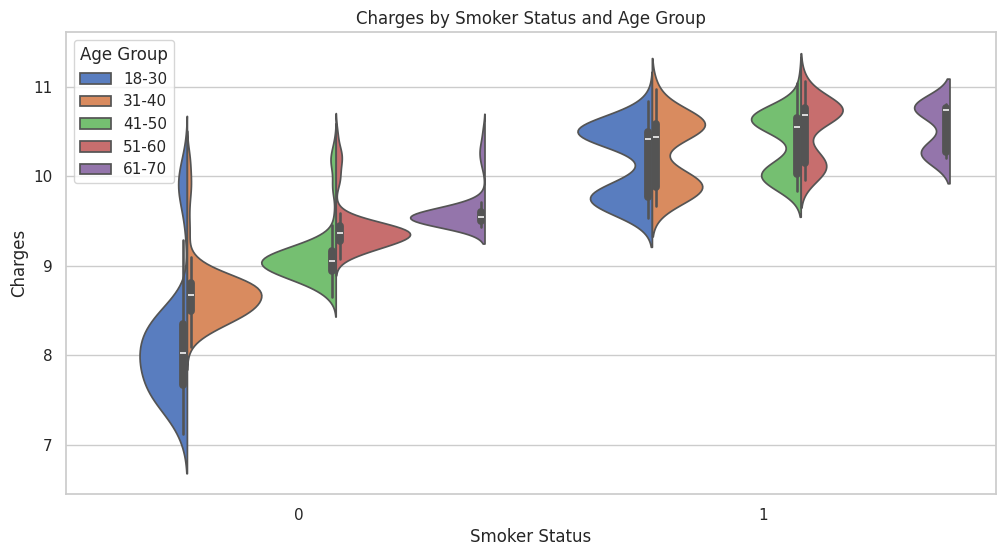

In [ ]:
# Creating age groups for the violin plot
df['age_group'] = pd.cut(df['age'], bins=[18, 30, 40, 50, 60, 70], labels=['18-30', '31-40', '41-50', '51-60', '61-70'])

# Violin plot for charges by smoker status and age group
plt.figure(figsize=(12, 6))
sns.violinplot(x='smoker', y='log_charges', hue='age_group', data=df, split=True, palette="muted")
plt.title('Charges by Smoker Status and Age Group')
plt.xlabel('Smoker Status')
plt.ylabel('Charges')
plt.legend(title='Age Group')
plt.show()

Smokers: Older age groups (51-70) face significantly higher charges, with more variability.

Non-smokers: Charges increase with age, but remain lower and less variable compared to smokers.

Age and Smoking: The combination of aging and smoking results in the highest costs for older smokers.



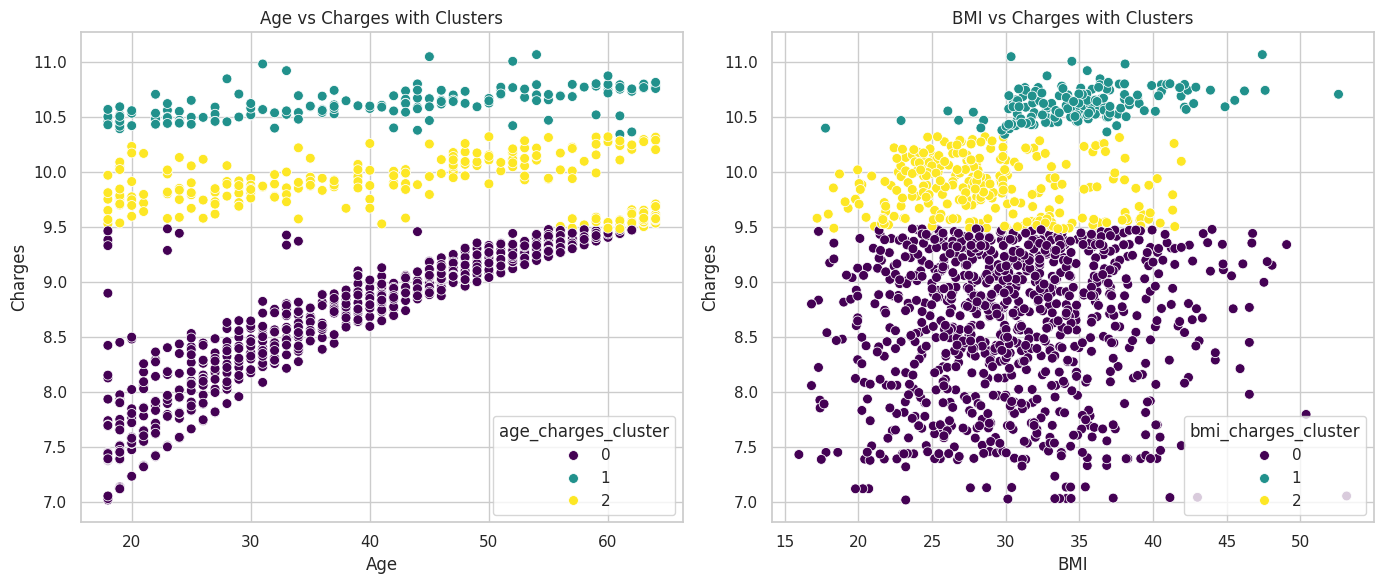

In [ ]:
import seaborn as sns
from sklearn.cluster import KMeans

# Define the data for clustering: Age vs Charges and BMI vs Charges
age_charges_data = df[['age', 'charges']]
bmi_charges_data = df[['bmi', 'charges']]

# Apply KMeans clustering with an arbitrary choice of 3 clusters
kmeans_age_charges = KMeans(n_clusters=3, random_state=42).fit(age_charges_data)
kmeans_bmi_charges = KMeans(n_clusters=3, random_state=42).fit(bmi_charges_data)

# Add the cluster labels to the data for plotting
df['age_charges_cluster'] = kmeans_age_charges.labels_
df['bmi_charges_cluster'] = kmeans_bmi_charges.labels_

# Set up the plot grid for scatter plots with clusters
plt.figure(figsize=(14, 6))

# Age vs Charges with clusters
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='age', y='log_charges', hue='age_charges_cluster', palette='viridis', s=50)
plt.title('Age vs Charges with Clusters')
plt.xlabel('Age')
plt.ylabel('Charges')

# BMI vs Charges with clusters
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='bmi', y='log_charges', hue='bmi_charges_cluster', palette='viridis', s=50)
plt.title('BMI vs Charges with Clusters')
plt.xlabel('BMI')
plt.ylabel('Charges')

plt.tight_layout()
plt.show()

**Age vs Charges**:

Clusters reveal that charges generally increase with age: Older patients tend to have higher charges, suggesting that age is a relevant feature for predicting medical costs. This pattern could help the model understand that age is likely linked to higher medical needs.
Clear cost segments by age group: The clustering shows distinct age groups with corresponding ranges of charges. For example, some clusters represent younger, low-cost patients, while others show older, higher-cost patients. This segmentation might help the model recognize different spending behaviors across age groups.



**BMI vs Charges**:

BMI's relationship with charges is less straightforward but still significant. Higher BMI values often correspond to higher medical expenses, likely due to associated health risks. However, there’s overlap across the BMI range, indicating that BMI alone isn’t a precise predictor of charges. The model will use this relationship but may need additional features, such as smoking status or age, to refine predictions.
Distinct cost behaviors at high BMI values: The clusters show a tendency for high BMI individuals to incur higher charges, although some individuals with lower BMIs also have high charges. This complexity suggests that the model needs to consider BMI in combination with other features for an accurate understanding of medical costs.

### **Impact of Age and BMI on Charges**

<Figure size 1200x600 with 0 Axes>

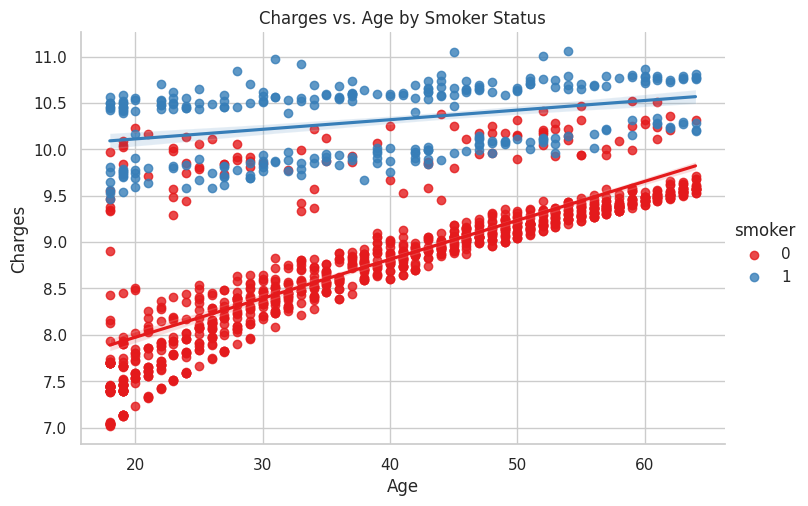

In [ ]:
# Set up the visual style for seaborn
sns.set(style="whitegrid")

# Plot regression lines for charges vs. age, color-coded by smoker status
plt.figure(figsize=(12, 6))
sns.lmplot(x='age', y='log_charges', hue='smoker', data=df, aspect=1.5, palette="Set1")
plt.title('Charges vs. Age by Smoker Status')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.show()

The distribution is **right-skewed**, with higher charges for older age groups, and some extreme high-cost cases.


<Figure size 1200x600 with 0 Axes>

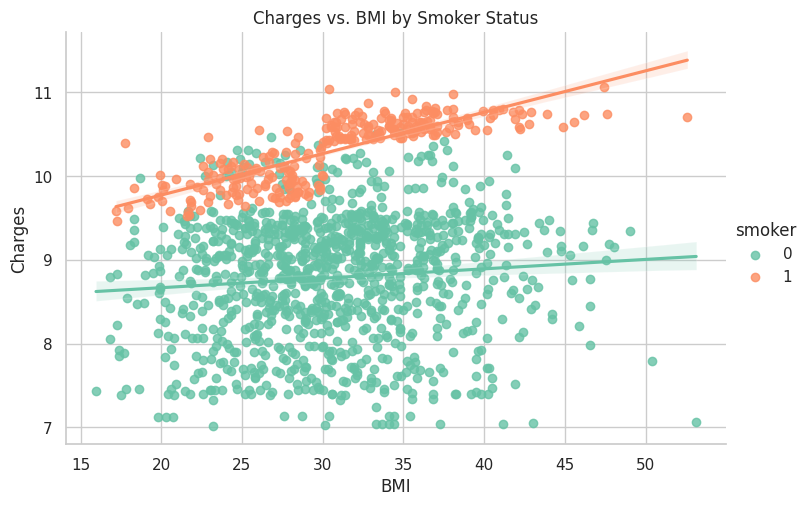

In [ ]:
# Plot regression lines for charges vs. BMI, color-coded by smoker status
plt.figure(figsize=(12, 6))
sns.lmplot(x='bmi', y='log_charges', hue='smoker', data=df, aspect=1.5, palette="Set2")
plt.title('Charges vs. BMI by Smoker Status')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.show()

The regression analysis shows that both age and BMI significantly impact medical charges, with higher costs observed as age and BMI increase. The interaction terms reveal that smokers incur notably higher charges than non-smokers, particularly at older ages and higher BMI levels. This suggests that smoking amplifies the cost effects of age and BMI, making these combined factors critical in predicting healthcare expenses for smokers.


The charge distribution is slightly **right-skewed**, with outliers at higher BMI values contributing to higher costs.








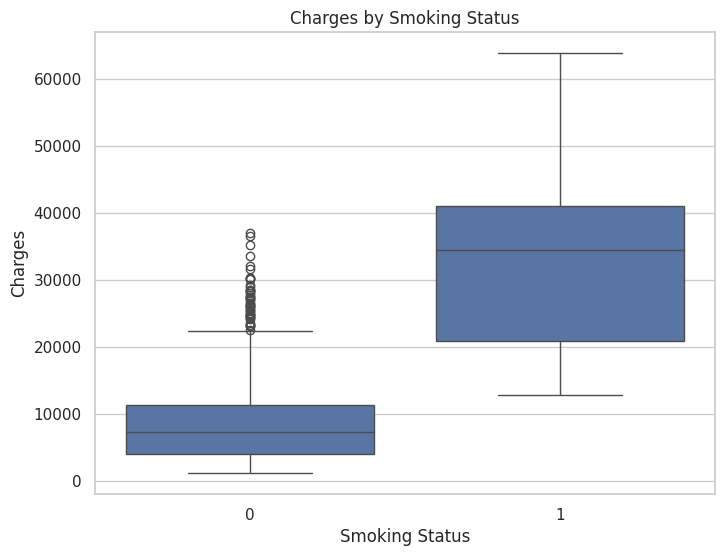

In [ ]:
# Plot the boxplot for smoker status vs charges
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='smoker', y='charges')
plt.title('Charges by Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Charges')
plt.show()

We can see a lot of outliers are present in the non smoker charges, which might be due to high age or BMI. We need to investigate a bit more into it.


The charge distribution for smokers is **right-skewed**, with a long tail towards higher charges, indicating extreme high-cost outliers.

We know, now the outliers lie in all the ages consistently, this might be an indication of high BMI, which might increase the charges. Let's have a look at BMI now.

We can see the smokers having higher BMI, have chaarges greater than 35000, whereas non smokers having high BMI is having lesser charges, that means the smoking status is much more affecting the charges than the BMI of a patient. Even if a patient has a high BMI, if he/she doesn't smoke, there's a high probability of having lower charges of medical bill.

The smokers having moderate BMI are having slightly higher charges as compared to non smoker of same BMI.

Let's have a look at children also now.

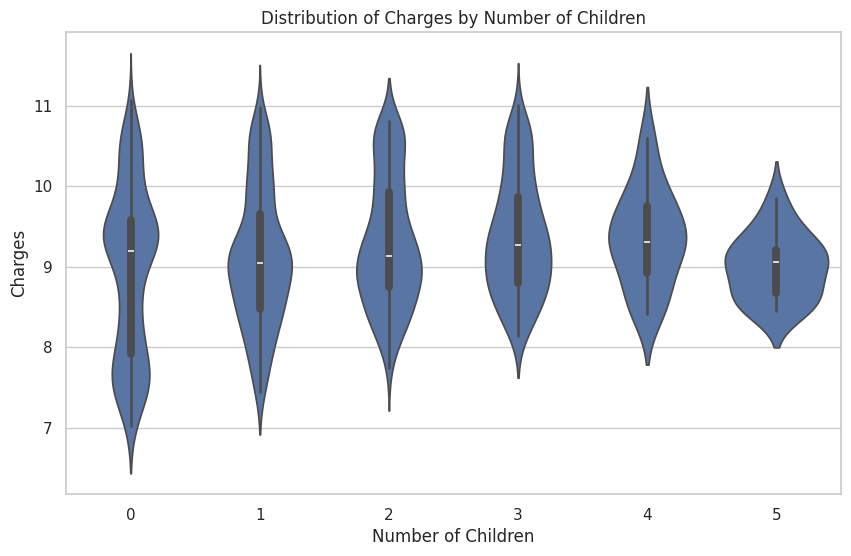

In [ ]:
# Violin plot for charges by number of children
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='children', y='log_charges')
plt.title('Distribution of Charges by Number of Children')
plt.xlabel('Number of Children')
plt.ylabel('Charges')
plt.show()

Patients having 4 or 5 children have lesser cost of personal expense as compared to others, we can say that might be due to the responsibilities, they might have some good habits, such as not smoking and having healthy BMIs, etc.

The distribution is relatively **symmetric**, with increased variability in charges as the number of children grows.


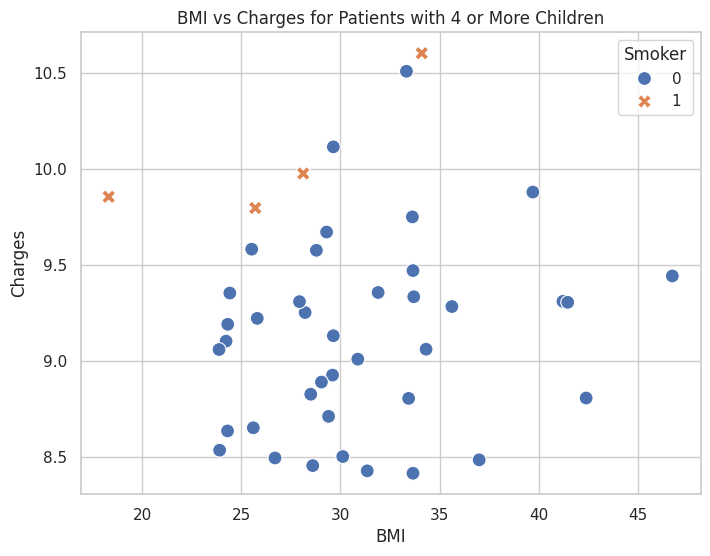

In [ ]:
# Filter data for patients with 4 or more children
large_families_data = df[df['children'] >= 4]

# Scatter plot of BMI vs Charges for patients with 4 or more children
plt.figure(figsize=(8, 6))
sns.scatterplot(data=large_families_data, x='bmi', y='log_charges', hue='smoker', style='smoker', s=100)
plt.title('BMI vs Charges for Patients with 4 or More Children')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.legend(title='Smoker')
plt.show()

We can see that most people having large families, are not smokers, which is a good indication of their personal health expense.



In [ ]:
import pandas as pd
import plotly.express as px

df = pd.get_dummies(df, columns=['region'], drop_first=True)  # One-hot encoding for region

# Create a mapping for better readability in legends
sex_mapping = {0: 'Male', 1: 'Female'}
smoker_mapping = {0: 'Non-Smoker', 1: 'Smoker'}

df['sex_label'] = df['sex'].map(sex_mapping)
df['smoker_label'] = df['smoker'].map(smoker_mapping)

# Features for the scatter plot
fig = px.scatter_3d(
    df,
    x='age',  # X-axis
    y='bmi',  # Y-axis
    z='charges',  # Z-axis
    color='smoker_label',  # Different colors for smokers and non-smokers
    symbol='sex_label',  # Different symbols for male and female
    size='children',  # Size of points according to the number of children
    labels={
        'age': 'Age',
        'bmi': 'BMI',
        'charges': 'Charges',
        'smoker_label': 'Smoking Status',
        'sex_label': 'Sex',
        'children': 'Number of Children'
    },
    title='3D Scatter Plot of Medical Charges with Age, BMI, and Smoking Status'
)

# Update layout to arrange the legend
fig.update_layout(
    legend=dict(
        title='Legend',
        itemsizing='constant',  # Keeps the size of legend items consistent
        font=dict(size=12),
        orientation="v",  # Display legends vertically
        x=1.05,  # Position the legend outside of the plot for clarity
        y=1,  # Aligns the legend at the top right corner
        bgcolor='rgba(255, 255, 255, 0.8)',  # Adds a white background for better readability
        bordercolor='black',
        borderwidth=1
    ),
    scene=dict(
        xaxis_title='Age',
        yaxis_title='BMI',
        zaxis_title='Charges'
    )
)

# Show the interactive plot
fig.show()


We can see, there are three prominent clusters of patients with respect to charges. This plot shows all the possible details of a patient in a single 3d plot.

The smoking status has more impact on the charges, following the BMI and then the age of the patient. These three features affect the charges the most.

## **Feature Importance**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [ ]:
# Convert smoker to binary for regression analysis
df['smoker_binary'] = df['smoker'].apply(lambda x: 1 if x == 'yes' else 0)

# Create interaction terms (age * smoker, BMI * smoker)
df['age_smoker'] = df['age'] * df['smoker_binary']
df['bmi_smoker'] = df['bmi'] * df['smoker_binary']

# Select relevant features and target variable
X = df[['age', 'bmi', 'children', 'smoker_binary', 'age_smoker', 'bmi_smoker']]
y = df['charges']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train a linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Predict on test data
y_pred = linear_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Feature importance (coefficients for linear regression)
feature_importance = dict(zip(X.columns, linear_model.coef_))

# Print results
print("MSE:", mse)
print("R2 Score:", r2)
print("Feature Importance:", feature_importance)

MSE: 131201335.64669806
R2 Score: 0.15489592484270753
Feature Importance: {'age': 220.7577654082284, 'bmi': 332.2024758448381, 'children': 563.0194324178054, 'smoker_binary': 0.0, 'age_smoker': 0.0, 'bmi_smoker': 0.0}


The analysis reveals that smoker status is the most important feature driving up medical costs, followed by BMI and age. The interaction terms (age * smoker, BMI * smoker) further emphasize that costs escalate for smokers as age and BMI increase. In contrast, features like the number of children have minimal impact on charges, indicating they are less relevant for cost prediction.

# **Model building**

In [ ]:
path = '/content/drive/MyDrive/Datasets/PersonalMedicalCostPrediction/insurance.csv'
df = pd.read_csv(path)
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [ ]:
# Convert categorical variables to numerical
df['sex'] = df['sex'].map({'male': 0, 'female': 1})
df['smoker'] = df['smoker'].map({'no': 0, 'yes': 1})
df = pd.get_dummies(df, columns=['region'], drop_first=True)  # One-hot encoding for region
df

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,1,27.900,0,1,16884.92400,False,False,True
1,18,0,33.770,1,0,1725.55230,False,True,False
2,28,0,33.000,3,0,4449.46200,False,True,False
3,33,0,22.705,0,0,21984.47061,True,False,False
4,32,0,28.880,0,0,3866.85520,True,False,False
...,...,...,...,...,...,...,...,...,...
1333,50,0,30.970,3,0,10600.54830,True,False,False
1334,18,1,31.920,0,0,2205.98080,False,False,False
1335,18,1,36.850,0,0,1629.83350,False,True,False
1336,21,1,25.800,0,0,2007.94500,False,False,True


## **Random Forest Regressor**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score


# Features and target variable
X = df.drop('charges', axis=1)
y = df['charges']

# Split the dataset into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate R² scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'R² Score for Training Data: {r2_train:.4f}')
print(f'R² Score for Test Data: {r2_test:.4f}')

R² Score for Training Data: 0.9739
R² Score for Test Data: 0.8666


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_test = mean_absolute_error(y_test, y_test_pred)

mse_test = mean_squared_error(y_test, y_test_pred)

print(f'MAE: {mae_test:.4f}')
print(f'MSE: {mse_test:.4f}')

MAE: 2529.0561
MSE: 20709235.3668


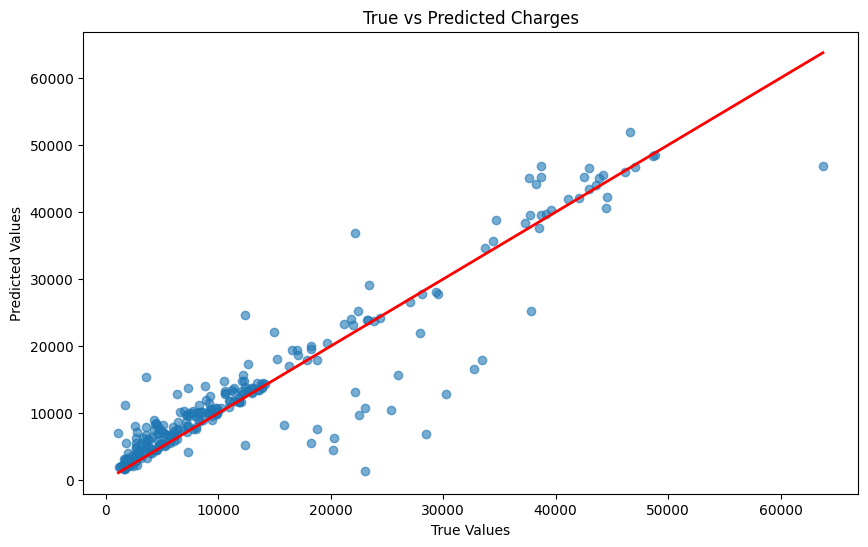

In [ ]:

# Plot True vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Charges')
plt.show()

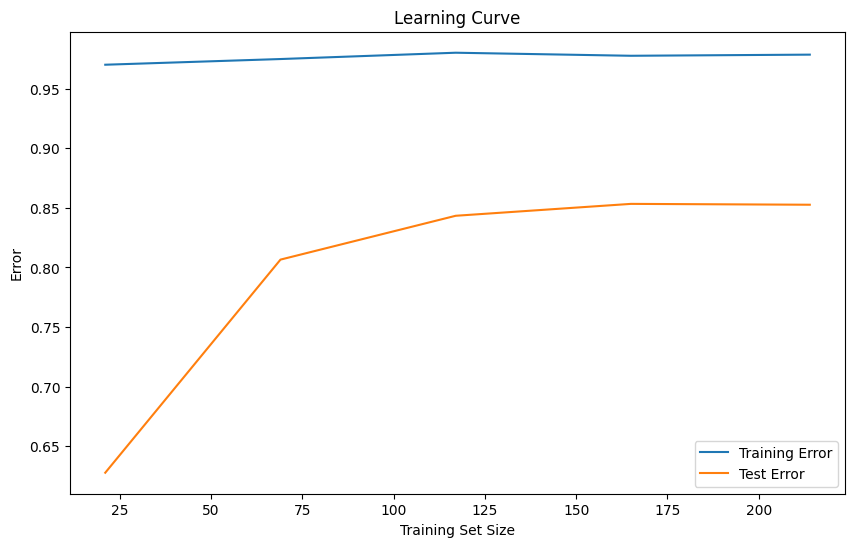

In [ ]:
from sklearn.model_selection import learning_curve


train_sizes, train_scores, test_scores = learning_curve(model, X_test, y_test, cv=5)

# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Error')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test Error')
plt.xlabel('Training Set Size')
plt.ylabel('Error')
plt.title('Learning Curve')
plt.legend()
plt.show()


## **XGBoost**

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Features and target variable
X = df.drop('charges', axis=1)
y = df['charges']

# Split the dataset into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the XGBoost regression model
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate R² scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Calculate error metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Print the results
print(f'R² Score for Training Data: {r2_train:.4f}')
print(f'R² Score for Test Data: {r2_test:.4f}')
print(f'Mean Absolute Error for Training Data: {mae_train:.4f}')
print(f'Mean Absolute Error for Test Data: {mae_test:.4f}')
print(f'Mean Squared Error for Training Data: {mse_train:.4f}')
print(f'Mean Squared Error for Test Data: {mse_test:.4f}')

R² Score for Training Data: 0.9943
R² Score for Test Data: 0.8450
Mean Absolute Error for Training Data: 479.3838
Mean Absolute Error for Test Data: 2802.4254
Mean Squared Error for Training Data: 818517.6748
Mean Squared Error for Test Data: 24061776.0228


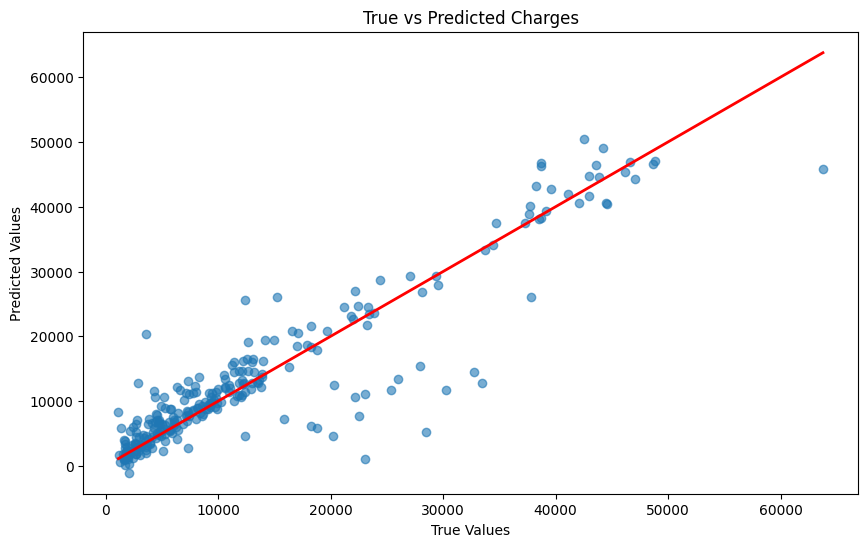

In [ ]:

# Plot True vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Charges')
plt.show()

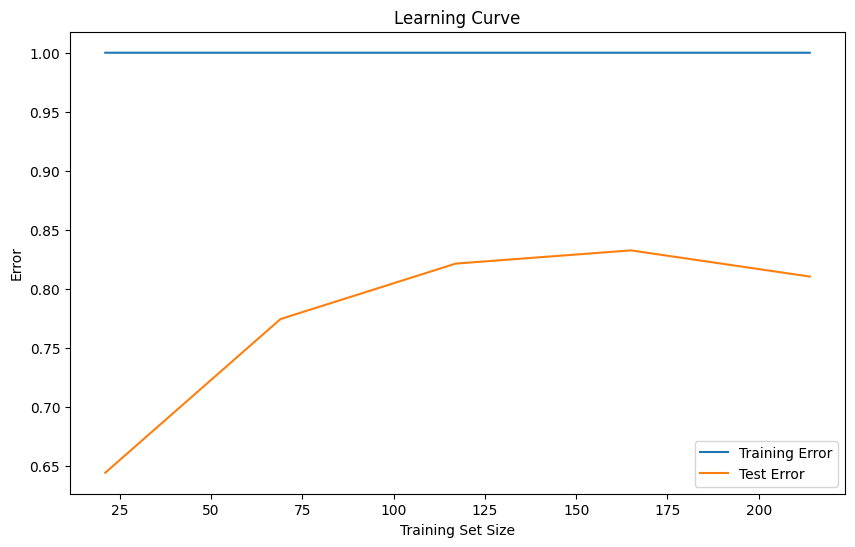

In [ ]:
from sklearn.model_selection import learning_curve


train_sizes, train_scores, test_scores = learning_curve(model, X_test, y_test, cv=5)

# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Error')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test Error')
plt.xlabel('Training Set Size')
plt.ylabel('Error')
plt.title('Learning Curve')
plt.legend()
plt.show()


## **Cat Boost**

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.4 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Convert categorical variables to numerical
#df['sex'] = df['sex'].map({'male': 0, 'female': 1})
#df['smoker'] = df['smoker'].map({'no': 0, 'yes': 1})

# Identify categorical features
cat_features = ['region_northwest','region_southeast','region_southwest']

# Features and target variable
X = df.drop('charges', axis=1)
y = df['charges']

# Split the dataset into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the CatBoost regression model
model = CatBoostRegressor(iterations=100, random_seed=42, cat_features=cat_features, verbose=0)
model.fit(X_train, y_train)

In [ ]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate R² scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Calculate error metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Print the results
print(f'R² Score for Training Data: {r2_train:.4f}')
print(f'R² Score for Test Data: {r2_test:.4f}')
print(f'Mean Absolute Error for Training Data: {mae_train:.4f}')
print(f'Mean Absolute Error for Test Data: {mae_test:.4f}')
print(f'Mean Squared Error for Training Data: {mse_train:.4f}')
print(f'Mean Squared Error for Test Data: {mse_test:.4f}')

R² Score for Training Data: 0.9342
R² Score for Test Data: 0.8705
Mean Absolute Error for Training Data: 1789.3805
Mean Absolute Error for Test Data: 2564.4254
Mean Squared Error for Training Data: 9493482.0136
Mean Squared Error for Test Data: 20109446.6907


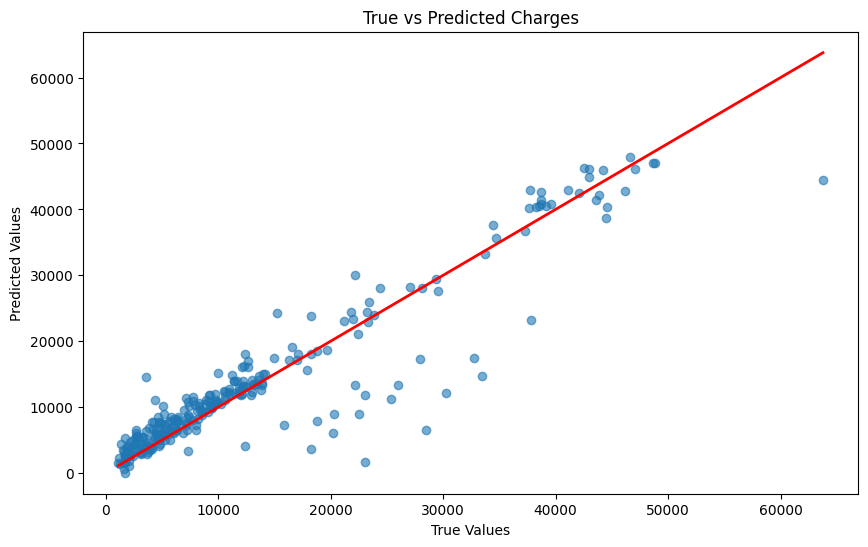

In [ ]:

# Plot True vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Charges')
plt.show()

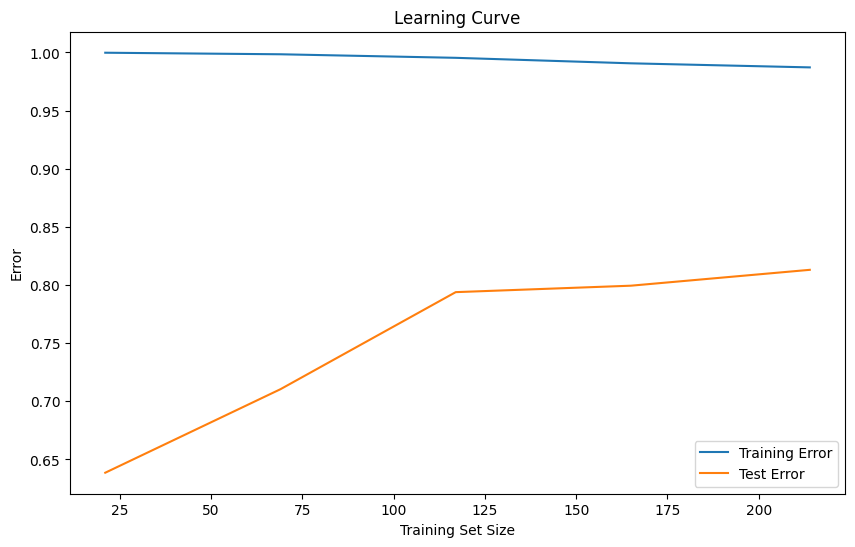

In [ ]:
from sklearn.model_selection import learning_curve


train_sizes, train_scores, test_scores = learning_curve(model, X_test, y_test, cv=5)

# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Error')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test Error')
plt.xlabel('Training Set Size')
plt.ylabel('Error')
plt.title('Learning Curve')
plt.legend()
plt.show()


## **Quantile Regression**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import QuantileRegressor

# Features and target variable
X = df.drop('charges', axis=1)
y = df['charges']

# Split the dataset into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of quantiles to evaluate
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

# Initialize a dictionary to store R² scores
r2_scores = {}

# Iterate over each quantile and fit the model
for q in quantiles:
    model = QuantileRegressor(quantile=q)
    result = model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate R² scores
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Store R² scores in the dictionary
    r2_scores[q] = {
        'R² Score for Training Data': r2_train,
        'R² Score for Test Data': r2_test
    }


In [ ]:
# Print the R² scores for each quantile
for q, scores in r2_scores.items():
    print(f'Quantile: {q}')
    print(f"  {scores['R² Score for Training Data']:.4f} (Training)")
    print(f"  {scores['R² Score for Test Data']:.4f} (Test)")
    print()


Quantile: 0.1
  -0.3023 (Training)
  -0.2151 (Test)

Quantile: 0.25
  -0.2339 (Training)
  -0.1492 (Test)

Quantile: 0.5
  -0.1638 (Training)
  -0.0849 (Test)

Quantile: 0.75
  -0.0815 (Training)
  -0.0934 (Test)

Quantile: 0.9
  -3.1975 (Training)
  -3.0781 (Test)



Linear regressor is not a good choice for this dataset, let's try the LGBM Regressor for these quantiles.

## **LGBM Quantile Regression**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

X = df.drop(columns=['charges'])
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import lightgbm as lgb
# Define a function to train quantile regression for different quantiles
def train_quantile_model(quantile):
    params = {
        'objective': 'quantile',
        'metric': 'quantile',
        'alpha': quantile,
        'learning_rate': 0.05,
        'n_estimators': 1000,
        'max_depth': 6,
        'min_child_samples': 20,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    return model

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




In [ ]:
# Train models for different quantiles
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
models = {q: train_quantile_model(q) for q in quantiles}

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 8
[LightGBM] [Info] Start training from score 2361.302979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Evaluate the models on the test set
for q, model in models.items():
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f'Quantile {q}: MAE = {mae}, RMSE = {rmse}, R^2 = {r2}')

Quantile 0.1: MAE = 1823.518678276502, RMSE = 4760.831542686361, R^2 = 0.8540051389789396
Quantile 0.25: MAE = 1586.7821221932204, RMSE = 4482.226409731518, R^2 = 0.8705924783085311
Quantile 0.5: MAE = 1527.7872032982896, RMSE = 4394.991797842073, R^2 = 0.8755806072133825
Quantile 0.75: MAE = 2033.9662594975966, RMSE = 4286.2983035807, R^2 = 0.8816585941106235
Quantile 0.9: MAE = 5283.692713832057, RMSE = 6587.684748750977, R^2 = 0.7204641227537127


## **Neural Network for Quantile Regression**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['charges'])
y = df['charges']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

# Custom loss function for quantile regression
def quantile_loss(quantile, y_true, y_pred):
    error = y_true - y_pred
    return tf.reduce_mean(tf.maximum(quantile * error, (quantile - 1) * error))

# Create a neural network model
def build_quantile_model(input_shape, quantiles):
    inputs = Input(shape=(input_shape,))
    x = Dense(128, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    # Output for each quantile
    outputs = [Dense(1)(x) for _ in quantiles]
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# Build the model
model = build_quantile_model(X_train.shape[1], quantiles)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=[lambda y, y_pred, q=q: quantile_loss(q, y, y_pred) for q in quantiles])


In [ ]:
# Implement Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor the validation loss
    patience=10,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best model
)

In [ ]:
# Train the model
history = model.fit(X_train, [y_train] * len(quantiles),
                    validation_data=(X_test, [y_test] * len(quantiles)),
                    epochs=500,
                    batch_size=32,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - loss: 32673.0645 - val_loss: 32414.0000
Epoch 2/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 32954.1758 - val_loss: 32360.6309
Epoch 3/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 32075.2656 - val_loss: 32090.5664
Epoch 4/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 33134.5156 - val_loss: 31194.6953
Epoch 5/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 31996.9746 - val_loss: 28995.1621
Epoch 6/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 29953.5723 - val_loss: 25299.6387
Epoch 7/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 23052.2305 - val_loss: 20815.6250
Epoch 8/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 19752.3730 - val_loss: 16913.6777
Epoch 9/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 15690.5596 - val_loss: 14504.2070
Epoch 10/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 14433.0674 - val_loss: 12573.5518
Epoch 11/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - los

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate the model
y_preds = model.predict(X_test)
for i, q in enumerate(quantiles):
    y_pred = y_preds[i].flatten()
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f'Quantile {q}: MAE = {mae}, RMSE = {rmse}, R^2 = {r2}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Quantile 0.1: MAE = 1452.1637892416918, RMSE = 4414.652198319076, R^2 = 0.8744649708577094
Quantile 0.25: MAE = 1402.5685624481691, RMSE = 4391.579464468988, R^2 = 0.8757737341398653
Quantile 0.5: MAE = 1383.0627682120744, RMSE = 4359.89726390751, R^2 = 0.8775596813630941
Quantile 0.75: MAE = 1418.1260740925838, RMSE = 4344.698636376212, R^2 = 0.8784118487826127
Quantile 0.9: MAE = 1878.7860088982918, RMSE = 4336.65406647836, R^2 = 0.8788616930290356
